In [1]:
!python -V

Python 3.9.12


## No queremos estar repitiendo la ejecución de este proceso celda por celda
---

Vamos a crear funciones para este proceso

In [8]:
# los más de los duros, los reales, los meros buenos
import pandas as pd
import numpy as np

# para graficar
import matplotlib.pyplot as plt
import seaborn as sns   

# libreria que usaremos para aprendizaje
import sklearn

# para preprocesamiento
from sklearn.feature_extraction import DictVectorizer

# los modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# las metricas
from sklearn.metrics import mean_squared_error

In [9]:
# la funcion para leer los datos
def leer_dataframe(filename):

    df = pd.read_parquet(filename)

    # parseamos el string a datetime
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df.duration.apply(lambda x: x.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <=60)]

    # convirtiendo la duracion a segundos
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df
    

In [11]:
df_train = leer_dataframe('./01-intro/data/green_tripdata_2021-01.parquet')
df_val = leer_dataframe('./01-intro/data/green_tripdata_2021-02.parquet')
print(df_train.shape, df_val.shape)

(73908, 21) (61921, 21)


In [12]:
print(df_train.PULocationID.nunique())
print(df_train.DOLocationID.nunique())

250
256


In [13]:
print(df_val.PULocationID.nunique())
print(df_val.DOLocationID.nunique())

245
254


## Creando un nuevo feature
---

In [14]:
# creando un nuevo feature
df_train["PU_LO"] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val["PU_LO"] = df_val.PULocationID + '_' + df_val.DOLocationID

In [15]:
categorical = ["PU_LO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts) # OJO aqui solo usamos transform

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


7.4793657829373155


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


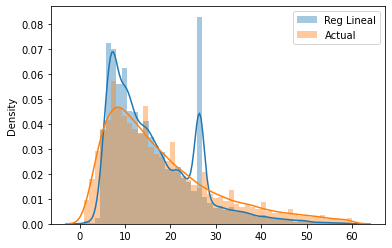

In [16]:
# entrenando Regresion Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

y_pred_rl = rl.predict(X_val)

print(mean_squared_error(y_val, y_pred_rl, squared=False))
sns.distplot(y_pred_rl, label='Reg Lineal')
sns.distplot(y_val, label='Actual')
plt.legend();

In [30]:
import pickle
with open("/workspaces/learning-mlops/02-exp-tracking/models/lin_reg2.bin", "wb") as f:
    pickle.dump((dv,rl), f)

9.233436225720547


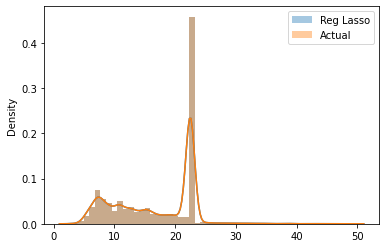

In [227]:
# entrenando Regresion Lineal
rl_lasso = Lasso(0.001)
rl_lasso.fit(X_train, y_train)

y_pred_lasso = rl_lasso.predict(X_val)

print(mean_squared_error(y_val, y_pred_lasso, squared=False))
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_pred_lasso, label='Actual')
plt.legend();